## Import data

In [1]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


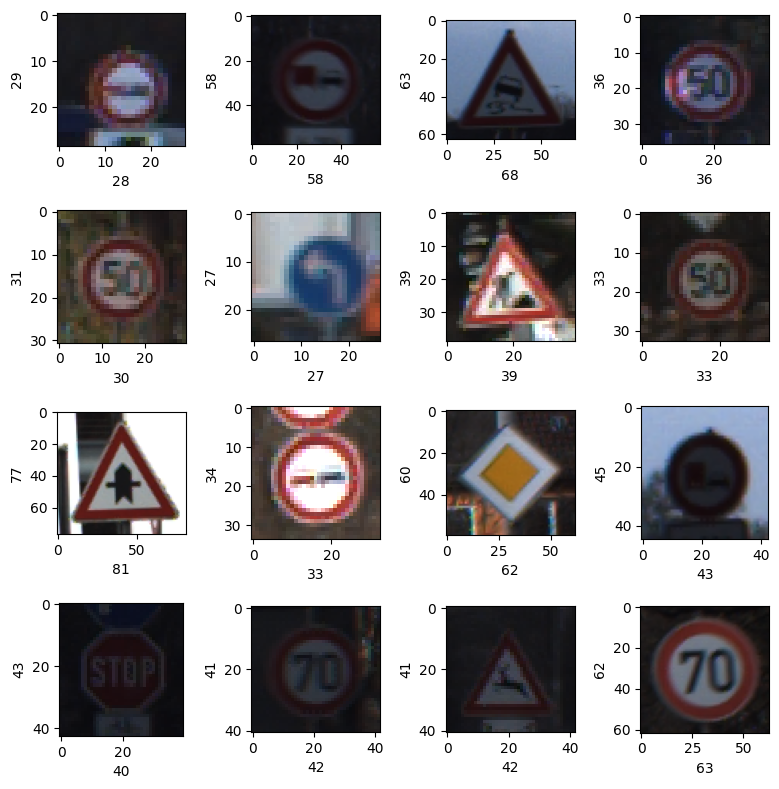

In [2]:
# Plotting 12 images to check dataset
plt.figure(figsize=(8,8))
path = "/kaggle/input/gtsrb-german-traffic-sign/Test"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)  # width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)  # height of image

In [3]:
# Check mean of image size
dim1 = []
dim2 = []

img_list = os.listdir(path)
img_list.sort()

In [4]:
img_list[:30]

['00000.png',
 '00001.png',
 '00002.png',
 '00003.png',
 '00004.png',
 '00005.png',
 '00006.png',
 '00007.png',
 '00008.png',
 '00009.png',
 '00010.png',
 '00011.png',
 '00012.png',
 '00013.png',
 '00014.png',
 '00015.png',
 '00016.png',
 '00017.png',
 '00018.png',
 '00019.png',
 '00020.png',
 '00021.png',
 '00022.png',
 '00023.png',
 '00024.png',
 '00025.png',
 '00026.png',
 '00027.png',
 '00028.png',
 '00029.png']

In [5]:
len(img_list)

12631

In [6]:
# Check average of image dimensiion

for i in range(len(img_list)):
    path = f'/kaggle/input/gtsrb-german-traffic-sign/Test/{img_list[i]}'

    # Check if the file is a JPG or PNG
    if os.path.splitext(path)[1].lower() in ['.jpg', '.jpeg', '.png']:
        img = imread(path)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])
    else:
        pass

In [7]:
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.36444972288203  Dimension 2 Mean :  50.50775930324624


## Data pre-processing

In [8]:
label = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Test.csv")

In [9]:
label.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [10]:
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null  object
dtypes: int64(7), object(1)
memory usage: 789.5+ KB


In [11]:
# Now we will reshape the images to (50,50)
images = []
label_id = []

for i in range(len(img_list)):
    path = f'/kaggle/input/gtsrb-german-traffic-sign/Test/{img_list[i]}'
    if os.path.splitext(path)[1].lower() in ['.jpg', '.jpeg', '.png']:
        img = Image.open(path)
        img = img.resize((50, 50))
        img = np.array(img)
        images.append(img)
        label_id.append(label['ClassId'].loc[i])
    else:
        pass

In [12]:
print(images[2].shape)

(50, 50, 3)


In [13]:
len(images)

12630

In [14]:
type(images)

list

In [15]:
# Converting images into numpy array
images = np.array(images)

# Image normalization.
images = images/255 

In [16]:
label_id = np.array(label_id)
label_id.shape

(12630,)

In [17]:
images.shape

(12630, 50, 50, 3)

## Generalize the data

In [18]:
# Split to train and test data
X_train, X_temp, y_train, y_temp = train_test_split(images, label_id, test_size=0.3, random_state=42)

# Spilt ot validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

# Print the sizes of each set
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 8841
Validation set size: 3410
Test set size: 379


In [19]:
X_train.shape[1:]

(50, 50, 3)

## Model

In [85]:
from tensorflow.keras.applications import VGG16

input_shape = X_train.shape[1:]

# Load pre-trained VGG16 model
base_model = VGG16(
    weights='imagenet', 
    include_top=False,  # Exclude the fully connected layers
    input_shape=input_shape,
    pooling='max',
)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))  # Adjust the number of classes based on your dataset

In [86]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 43)                5547      
                                                                 
Total params: 14884459 (56.78 MB)
Trainable params: 16

In [111]:
# Training the model
epochs = 40
batch_size = 128
fit_model = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val), verbose = 2)

Epoch 1/40
70/70 - 2s - loss: 0.1090 - accuracy: 0.9673 - val_loss: 0.2504 - val_accuracy: 0.9334 - 2s/epoch - 32ms/step
Epoch 2/40
70/70 - 2s - loss: 0.1131 - accuracy: 0.9684 - val_loss: 0.2510 - val_accuracy: 0.9337 - 2s/epoch - 27ms/step
Epoch 3/40
70/70 - 2s - loss: 0.1028 - accuracy: 0.9707 - val_loss: 0.2502 - val_accuracy: 0.9349 - 2s/epoch - 27ms/step
Epoch 4/40
70/70 - 2s - loss: 0.1033 - accuracy: 0.9718 - val_loss: 0.2535 - val_accuracy: 0.9349 - 2s/epoch - 27ms/step
Epoch 5/40
70/70 - 2s - loss: 0.0984 - accuracy: 0.9722 - val_loss: 0.2493 - val_accuracy: 0.9370 - 2s/epoch - 27ms/step
Epoch 6/40
70/70 - 2s - loss: 0.0900 - accuracy: 0.9740 - val_loss: 0.2482 - val_accuracy: 0.9381 - 2s/epoch - 26ms/step
Epoch 7/40
70/70 - 2s - loss: 0.0953 - accuracy: 0.9726 - val_loss: 0.2367 - val_accuracy: 0.9416 - 2s/epoch - 27ms/step
Epoch 8/40
70/70 - 2s - loss: 0.0993 - accuracy: 0.9696 - val_loss: 0.2607 - val_accuracy: 0.9364 - 2s/epoch - 26ms/step
Epoch 9/40
70/70 - 2s - loss: 0.

## Evaluate model

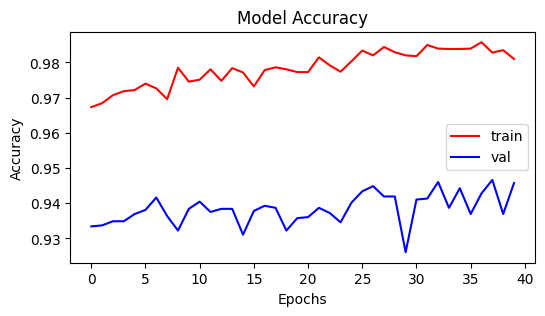

In [128]:
# Plot the training history
plt.figure(figsize=(6, 3))
plt.plot(fit_model.history['accuracy'], color='r')
plt.plot(fit_model.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

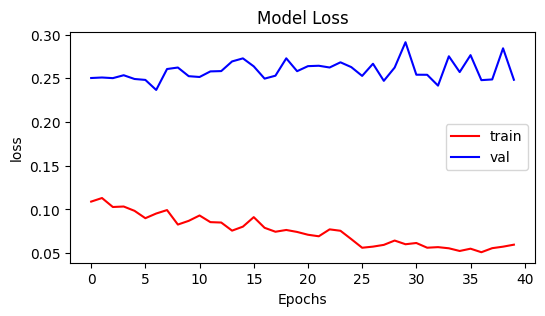

In [129]:
# Plot the training history
plt.figure(figsize=(6, 3))
plt.plot(fit_model.history['loss'], color='r')
plt.plot(fit_model.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [130]:
Y_pred = model.predict(X_val)
score = model.evaluate(X_val, y_val)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

107/107 [==============================] - 1s 8ms/step - loss: 0.6334 - accuracy: 0.8475
Accuracy over the test set: 
  84.75 %


## Test

In [115]:
# Storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

In [116]:
Y_pred_probabilities = model.predict(X_test)
Y_pred_test = np.argmax(Y_pred_probabilities, axis=1)

12/12 [==============================] - 0s 7ms/step


In [117]:
print(f'Length X_test: {len(X_test)}')
print(f'Length y_test: {len(y_test)}')
print(f'Length Y_pred_test: {len(Y_pred_test)}')

Length X_test: 379
Length y_test: 379
Length Y_pred_test: 379


In [118]:
y_test

array([38,  3, 38, 38,  3, 25, 18,  5,  9,  4, 27,  9,  5, 20, 15,  2, 18,
        8,  4, 33, 35, 35, 38, 38, 25, 16, 29, 35, 30, 18, 38, 25,  1,  8,
       10, 28, 20, 42, 15,  2,  8,  5,  6, 25, 25,  2,  5,  8,  3, 28, 10,
       13, 17, 25,  3,  4, 14, 11, 18, 34,  7, 38,  7, 38, 15, 38,  5, 31,
       38,  4,  2,  3, 10,  3, 10, 14,  5,  4,  5, 26,  8, 18, 29,  8, 12,
        1,  2, 18, 35, 25, 19, 35, 10, 38, 10, 10, 10, 10,  4, 17,  3,  2,
        5, 31, 36, 12, 12, 25, 25, 33, 38,  7, 30, 12, 18, 13,  6,  3,  5,
       17,  5, 16,  1,  9, 35, 25, 10,  1,  9, 38, 38, 12, 12,  2,  4, 13,
       11, 28,  4, 13, 15, 35,  1, 31, 11,  2, 12,  7,  2, 25,  8,  2, 31,
       13, 10,  4,  7, 12, 12,  2,  4, 10, 10, 38, 15,  6, 11, 38, 17, 17,
        8, 25, 11,  0,  2,  1, 11, 13,  3, 11, 38, 31, 22,  2, 11,  5, 18,
        9,  1, 26,  2, 15, 10,  5, 13, 38,  7,  9,  9,  7, 25, 14, 33, 13,
       38,  9, 31, 12, 33, 10,  3,  1, 33,  2, 13, 17,  7, 35, 25,  4, 13,
       18, 38, 33, 10,  8

In [119]:
Y_pred_test

array([38,  3, 12, 38,  3, 25, 18,  5,  9,  4, 27,  9,  5, 20, 15,  2, 18,
        8,  4, 33, 35, 35, 38, 38, 25, 16, 29, 35, 30, 26, 38, 30,  1,  8,
       10, 23, 20, 42, 15,  2,  8,  4,  6, 25, 25,  2,  5,  3,  3, 21, 10,
       13, 17, 25,  1, 30, 14, 25, 18, 34,  7, 38,  7, 38, 15, 38,  4, 30,
       38,  4,  2,  3,  7,  3, 10, 35,  5,  4,  5, 18,  8, 18, 29,  7, 12,
        1,  2, 25, 35, 25, 19, 38,  3, 13, 10, 10,  6, 10,  4,  4,  3,  2,
        5, 22, 38, 12, 12, 30, 28, 33, 38,  7, 30, 12, 18, 13,  6,  4,  3,
       17,  5, 16,  1,  9, 35, 25, 10,  1,  9, 38, 38, 12, 12,  3,  4, 13,
       11, 28,  5, 13, 15, 35,  1, 31, 11,  2, 12,  3,  2, 25,  3,  2, 31,
       13, 10,  4,  7, 12, 12,  2,  4,  7,  9, 38, 15,  6, 11, 39, 17, 17,
        4, 11, 11,  0,  2,  1, 29, 13,  3, 11, 38, 31, 20,  2, 11,  5, 24,
        9,  1, 26,  2, 15, 10,  5, 13, 38,  7, 40,  9,  7, 25, 14, 33, 13,
       38,  8, 31, 12, 33, 10,  4,  1, 33,  2, 13, 17,  3, 35, 25,  4, 13,
       26, 38, 33,  9,  8

In [120]:
original_labels = [all_lables[y_test[idx]] for idx in range(len(y_test))]
predicted_labels = [all_lables[Y_pred_test[idx]] for idx in range(len(Y_pred_test))]

In [121]:
df = pd.DataFrame({'Original Label': original_labels, 'Predicted Label': predicted_labels})

In [122]:
df

,Original Label,Predicted Label
0,Keep right,Keep right
1,Speed limit (60km/h),Speed limit (60km/h)
2,Keep right,Priority road
3,Keep right,Keep right
4,Speed limit (60km/h),Speed limit (60km/h)
...,...,...
374,General caution,General caution
375,End of speed limit (80km/h),End of speed limit (80km/h)
376,Keep right,Ahead only
377,Speed limit (80km/h),Speed limit (60km/h)


In [123]:
df['Bool'] = (df['Original Label'] == df['Predicted Label']).astype(int)

In [124]:
df

,Original Label,Predicted Label,Bool
0,Keep right,Keep right,1
1,Speed limit (60km/h),Speed limit (60km/h),1
2,Keep right,Priority road,0
3,Keep right,Keep right,1
4,Speed limit (60km/h),Speed limit (60km/h),1
...,...,...,...
374,General caution,General caution,1
375,End of speed limit (80km/h),End of speed limit (80km/h),1
376,Keep right,Ahead only,0
377,Speed limit (80km/h),Speed limit (60km/h),0


In [125]:
df.shape[0]

379

In [126]:
len(df[df['Bool'] == 1])

298

In [127]:
print(f'accuracy : {len(df[df["Bool"] == 1])/ df.shape[0]*100}')

accuracy : 78.62796833773086
